In [1]:
# example of a dcgan on dogs
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot

import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import xml.etree.ElementTree as et
import tensorflow as tf
print(tf.__version__)
import shutil


Using TensorFlow backend.


1.14.0


In [2]:

# Batch norm layers are recommended in both the discriminator and generator models, except the output of the generator
# and input to the discriminator (from DCGAN paper). I found they don't work when momentum at default of 0.99, hence I
# set to 0.8.

# In GANs, the recommendation is to not use pooling layers, and instead use the stride. Already in brownlee implementation

# define the standalone discriminator model
def define_discriminator(in_shape=(64,64,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    # model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    # model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    # model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    return model

In [3]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 8x8 image
    n_nodes = 256 * 8 * 8
    model.add(Dense(n_nodes, input_dim=latent_dim))
    # model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 256)))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    # model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    # model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    # model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    model.summary()
    return model

In [4]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    model.summary()
    return model

In [5]:
def read_image(file, bounds):
    image = open_image(file, bounds)
    image = normalize_image(image)
    return image


def open_image(file, bounds):
    image = Image.open(file)
    image = image.crop(bounds)
    image = image.resize((64, 64))
    return np.array(image)


# Normalization, [-1,1] Range
def normalize_image(image):
    image = np.asarray(image, np.float32)
    image = image / 127.5 - 1
    return img_to_array(image)

# Restore, [0,255] Range
def denormalize_image(image):
    return ((image+1)*127.5).astype(np.uint8)


def load_images():
    images = []

    for breed in os.listdir('../input/annotation/Annotation/'):
        for dog in os.listdir('../input/annotation/Annotation/' + breed):
            tree = et.parse('../input/annotation/Annotation/' + breed + '/' + dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                box = o.find('bndbox')
                xmin = int(box.find('xmin').text)
                ymin = int(box.find('ymin').text)
                xmax = int(box.find('xmax').text)
                ymax = int(box.find('ymax').text)

            bounds = (xmin, ymin, xmax, ymax)
            try:
                image = read_image('../input/all-dogs/all-dogs/' + dog + '.jpg', bounds)
                images.append(image)
            except:
                print('No image', dog)

    return np.array(images)

In [6]:

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i])
    # save plot to file
    # filename = 'generated_plot_e%03d.png' % (epoch+1)
    # pyplot.savefig(filename)
    # pyplot.close()
    pyplot.show()

In [7]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    # filename = 'generator_model_%03d.h5' % (epoch+1)
    # g_model.save(filename)


In [8]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=500, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 1 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         295168    
__________

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/160, d1=0.683, d2=0.696 g=0.692
>1, 2/160, d1=0.585, d2=0.698 g=0.689


/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 3/160, d1=0.454, d2=0.706 g=0.681
>1, 4/160, d1=0.298, d2=0.732 g=0.659
>1, 5/160, d1=0.153, d2=0.794 g=0.615
>1, 6/160, d1=0.081, d2=0.894 g=0.576
>1, 7/160, d1=0.064, d2=0.964 g=0.574
>1, 8/160, d1=0.087, d2=0.936 g=0.610
>1, 9/160, d1=0.104, d2=0.835 g=0.698
>1, 10/160, d1=0.127, d2=0.700 g=0.832
>1, 11/160, d1=0.110, d2=0.578 g=1.015
>1, 12/160, d1=0.160, d2=0.524 g=1.053
>1, 13/160, d1=0.079, d2=0.511 g=1.042
>1, 14/160, d1=0.197, d2=0.554 g=0.900
>1, 15/160, d1=0.134, d2=0.595 g=0.831
>1, 16/160, d1=0.086, d2=0.608 g=0.813
>1, 17/160, d1=0.016, d2=0.602 g=0.826
>1, 18/160, d1=0.008, d2=0.588 g=0.850
>1, 19/160, d1=0.058, d2=0.586 g=0.863
>1, 20/160, d1=0.052, d2=0.626 g=0.883
>1, 21/160, d1=0.019, d2=0.858 g=0.897
>1, 22/160, d1=0.001, d2=1.243 g=0.863
>1, 23/160, d1=0.005, d2=1.099 g=0.942
>1, 24/160, d1=0.014, d2=0.616 g=1.280
>1, 25/160, d1=0.031, d2=0.351 g=1.652
>1, 26/160, d1=0.102, d2=0.364 g=1.392
>1, 27/160, d1=0.024, d2=0.431 g=1.268
>1, 28/160, d1=0.067, d2=0.448 g

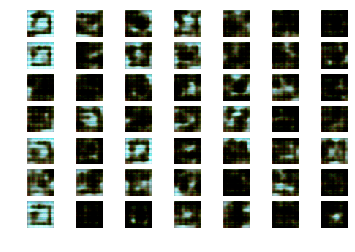

>2, 1/160, d1=0.812, d2=0.140 g=3.204
>2, 2/160, d1=0.517, d2=0.922 g=7.571
>2, 3/160, d1=1.381, d2=0.134 g=4.922
>2, 4/160, d1=0.863, d2=0.304 g=2.834
>2, 5/160, d1=0.399, d2=0.611 g=2.843
>2, 6/160, d1=0.329, d2=0.499 g=3.675
>2, 7/160, d1=0.637, d2=0.396 g=3.000
>2, 8/160, d1=0.792, d2=0.517 g=3.250
>2, 9/160, d1=0.652, d2=0.251 g=3.030
>2, 10/160, d1=0.675, d2=0.292 g=2.865
>2, 11/160, d1=0.554, d2=0.354 g=3.089
>2, 12/160, d1=0.554, d2=0.385 g=3.143
>2, 13/160, d1=0.542, d2=0.303 g=3.141
>2, 14/160, d1=0.569, d2=0.427 g=2.916
>2, 15/160, d1=0.850, d2=0.487 g=2.891
>2, 16/160, d1=0.773, d2=0.306 g=2.681
>2, 17/160, d1=0.686, d2=0.594 g=2.455
>2, 18/160, d1=0.743, d2=0.531 g=2.204
>2, 19/160, d1=0.872, d2=0.685 g=1.958
>2, 20/160, d1=0.704, d2=0.617 g=1.596
>2, 21/160, d1=0.706, d2=0.611 g=1.492
>2, 22/160, d1=0.591, d2=0.571 g=1.480
>2, 23/160, d1=0.769, d2=0.745 g=1.144
>2, 24/160, d1=0.604, d2=0.847 g=1.003
>2, 25/160, d1=0.387, d2=0.775 g=1.212
>2, 26/160, d1=0.513, d2=0.521 g=1

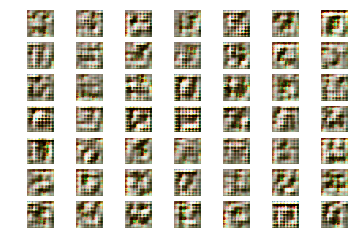

>3, 1/160, d1=0.391, d2=0.409 g=2.503
>3, 2/160, d1=0.478, d2=0.374 g=2.352
>3, 3/160, d1=0.538, d2=0.493 g=2.137
>3, 4/160, d1=0.505, d2=0.663 g=2.137
>3, 5/160, d1=0.826, d2=0.727 g=1.759
>3, 6/160, d1=0.624, d2=0.634 g=1.851
>3, 7/160, d1=0.776, d2=0.686 g=1.863
>3, 8/160, d1=0.711, d2=0.456 g=1.765
>3, 9/160, d1=0.588, d2=0.518 g=1.902
>3, 10/160, d1=0.601, d2=0.516 g=2.146
>3, 11/160, d1=0.703, d2=0.373 g=2.063
>3, 12/160, d1=0.545, d2=0.336 g=1.958
>3, 13/160, d1=0.494, d2=0.366 g=2.065
>3, 14/160, d1=0.436, d2=0.407 g=2.356
>3, 15/160, d1=0.530, d2=0.321 g=2.259
>3, 16/160, d1=0.613, d2=0.444 g=2.188
>3, 17/160, d1=0.505, d2=0.365 g=2.185
>3, 18/160, d1=0.565, d2=0.412 g=2.069
>3, 19/160, d1=0.576, d2=0.450 g=2.056
>3, 20/160, d1=0.655, d2=0.562 g=2.062
>3, 21/160, d1=0.749, d2=0.501 g=1.979
>3, 22/160, d1=0.751, d2=0.596 g=2.096
>3, 23/160, d1=0.904, d2=0.464 g=1.990
>3, 24/160, d1=0.675, d2=0.503 g=2.048
>3, 25/160, d1=0.612, d2=0.366 g=1.992
>3, 26/160, d1=0.675, d2=0.502 g=1

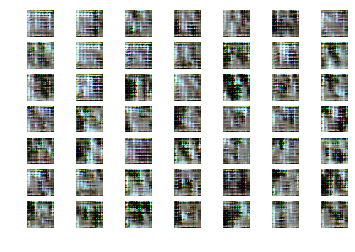

>4, 1/160, d1=0.734, d2=0.620 g=2.945
>4, 2/160, d1=0.738, d2=0.329 g=2.716
>4, 3/160, d1=0.755, d2=0.575 g=2.476
>4, 4/160, d1=0.774, d2=0.714 g=2.591
>4, 5/160, d1=0.626, d2=0.445 g=2.556
>4, 6/160, d1=0.802, d2=0.568 g=2.158
>4, 7/160, d1=0.606, d2=0.444 g=2.376
>4, 8/160, d1=0.614, d2=0.396 g=2.740
>4, 9/160, d1=0.658, d2=0.332 g=2.747
>4, 10/160, d1=0.706, d2=0.372 g=2.422
>4, 11/160, d1=0.492, d2=0.312 g=2.256
>4, 12/160, d1=0.506, d2=0.297 g=2.305
>4, 13/160, d1=0.397, d2=0.237 g=2.345
>4, 14/160, d1=0.489, d2=0.361 g=2.404
>4, 15/160, d1=0.429, d2=0.291 g=2.441
>4, 16/160, d1=0.304, d2=0.237 g=2.466
>4, 17/160, d1=0.404, d2=0.243 g=2.164
>4, 18/160, d1=0.457, d2=0.388 g=2.190
>4, 19/160, d1=0.401, d2=0.387 g=2.126
>4, 20/160, d1=0.294, d2=0.340 g=2.033
>4, 21/160, d1=0.593, d2=0.528 g=1.706
>4, 22/160, d1=0.476, d2=0.569 g=1.630
>4, 23/160, d1=0.542, d2=0.600 g=1.587
>4, 24/160, d1=0.574, d2=0.576 g=1.616
>4, 25/160, d1=0.542, d2=0.570 g=1.737
>4, 26/160, d1=0.614, d2=0.549 g=1

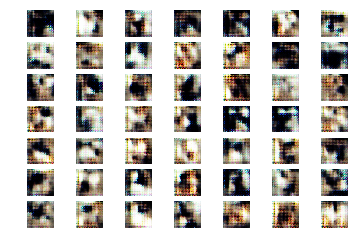

>5, 1/160, d1=0.615, d2=0.551 g=1.564
>5, 2/160, d1=0.575, d2=0.509 g=1.568
>5, 3/160, d1=0.595, d2=0.543 g=1.549
>5, 4/160, d1=0.659, d2=0.506 g=1.476
>5, 5/160, d1=0.618, d2=0.483 g=1.479
>5, 6/160, d1=0.522, d2=0.481 g=1.544
>5, 7/160, d1=0.530, d2=0.484 g=1.638
>5, 8/160, d1=0.522, d2=0.402 g=1.710
>5, 9/160, d1=0.543, d2=0.451 g=1.603
>5, 10/160, d1=0.492, d2=0.494 g=1.545
>5, 11/160, d1=0.497, d2=0.479 g=1.651
>5, 12/160, d1=0.465, d2=0.505 g=1.691
>5, 13/160, d1=0.589, d2=0.540 g=1.487
>5, 14/160, d1=0.578, d2=0.638 g=1.474
>5, 15/160, d1=0.543, d2=0.541 g=1.512
>5, 16/160, d1=0.602, d2=0.556 g=1.438
>5, 17/160, d1=0.631, d2=0.568 g=1.484
>5, 18/160, d1=0.613, d2=0.585 g=1.501
>5, 19/160, d1=0.575, d2=0.558 g=1.505
>5, 20/160, d1=0.499, d2=0.473 g=1.693
>5, 21/160, d1=0.540, d2=0.434 g=1.557
>5, 22/160, d1=0.393, d2=0.467 g=1.630
>5, 23/160, d1=0.521, d2=0.472 g=1.517
>5, 24/160, d1=0.418, d2=0.451 g=1.672
>5, 25/160, d1=0.519, d2=0.449 g=1.569
>5, 26/160, d1=0.451, d2=0.563 g=1

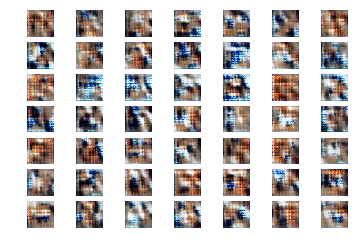

>6, 1/160, d1=0.741, d2=0.573 g=2.018
>6, 2/160, d1=0.663, d2=0.565 g=2.043
>6, 3/160, d1=0.852, d2=0.573 g=2.142
>6, 4/160, d1=0.809, d2=0.452 g=2.139
>6, 5/160, d1=0.645, d2=0.340 g=2.109
>6, 6/160, d1=0.640, d2=0.336 g=2.147
>6, 7/160, d1=0.532, d2=0.322 g=2.254
>6, 8/160, d1=0.607, d2=0.332 g=2.170
>6, 9/160, d1=0.475, d2=0.325 g=2.148
>6, 10/160, d1=0.478, d2=0.394 g=2.227
>6, 11/160, d1=0.540, d2=0.399 g=2.045
>6, 12/160, d1=0.739, d2=0.579 g=1.601
>6, 13/160, d1=0.500, d2=0.575 g=1.912
>6, 14/160, d1=0.642, d2=0.487 g=1.889
>6, 15/160, d1=0.664, d2=0.563 g=1.598
>6, 16/160, d1=0.577, d2=0.681 g=1.695
>6, 17/160, d1=0.587, d2=0.567 g=1.747
>6, 18/160, d1=0.701, d2=0.494 g=1.629
>6, 19/160, d1=0.653, d2=0.527 g=1.544
>6, 20/160, d1=0.645, d2=0.561 g=1.637
>6, 21/160, d1=0.683, d2=0.530 g=1.711
>6, 22/160, d1=0.648, d2=0.424 g=1.809
>6, 23/160, d1=0.512, d2=0.473 g=1.902
>6, 24/160, d1=0.741, d2=0.477 g=1.616
>6, 25/160, d1=0.479, d2=0.595 g=1.830
>6, 26/160, d1=0.583, d2=0.339 g=1

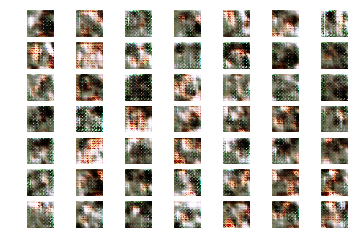

>7, 1/160, d1=0.624, d2=0.471 g=1.776
>7, 2/160, d1=0.551, d2=0.461 g=1.885
>7, 3/160, d1=0.461, d2=0.520 g=2.196
>7, 4/160, d1=0.529, d2=0.388 g=2.130
>7, 5/160, d1=0.534, d2=0.439 g=2.029
>7, 6/160, d1=0.525, d2=0.508 g=2.109
>7, 7/160, d1=0.513, d2=0.476 g=2.079
>7, 8/160, d1=0.574, d2=0.540 g=1.942
>7, 9/160, d1=0.556, d2=0.564 g=1.924
>7, 10/160, d1=0.704, d2=0.813 g=1.748
>7, 11/160, d1=0.681, d2=0.663 g=1.754
>7, 12/160, d1=0.600, d2=0.686 g=1.528
>7, 13/160, d1=0.691, d2=0.699 g=1.346
>7, 14/160, d1=0.823, d2=0.741 g=1.396
>7, 15/160, d1=0.621, d2=0.630 g=1.411
>7, 16/160, d1=0.664, d2=0.610 g=1.369
>7, 17/160, d1=0.609, d2=0.549 g=1.348
>7, 18/160, d1=0.503, d2=0.573 g=1.342
>7, 19/160, d1=0.496, d2=0.492 g=1.422
>7, 20/160, d1=0.471, d2=0.509 g=1.448
>7, 21/160, d1=0.394, d2=0.531 g=1.524
>7, 22/160, d1=0.402, d2=0.438 g=1.465
>7, 23/160, d1=0.426, d2=0.482 g=1.389
>7, 24/160, d1=0.422, d2=0.604 g=1.472
>7, 25/160, d1=0.378, d2=0.483 g=1.576
>7, 26/160, d1=0.472, d2=0.481 g=1

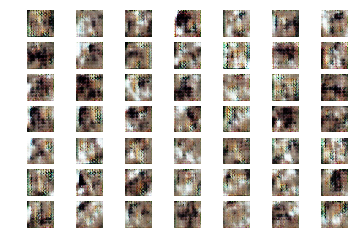

>8, 1/160, d1=0.408, d2=0.477 g=1.356
>8, 2/160, d1=0.380, d2=0.441 g=1.405
>8, 3/160, d1=0.378, d2=0.453 g=1.453
>8, 4/160, d1=0.363, d2=0.442 g=1.481
>8, 5/160, d1=0.460, d2=0.475 g=1.432
>8, 6/160, d1=0.450, d2=0.521 g=1.310
>8, 7/160, d1=0.428, d2=0.473 g=1.349
>8, 8/160, d1=0.387, d2=0.525 g=1.408
>8, 9/160, d1=0.462, d2=0.505 g=1.407
>8, 10/160, d1=0.439, d2=0.557 g=1.451
>8, 11/160, d1=0.497, d2=0.456 g=1.453
>8, 12/160, d1=0.531, d2=0.470 g=1.414
>8, 13/160, d1=0.469, d2=0.509 g=1.530
>8, 14/160, d1=0.446, d2=0.437 g=1.635
>8, 15/160, d1=0.562, d2=0.529 g=1.614
>8, 16/160, d1=0.426, d2=0.393 g=1.698
>8, 17/160, d1=0.531, d2=0.478 g=1.689
>8, 18/160, d1=0.481, d2=0.410 g=1.711
>8, 19/160, d1=0.516, d2=0.453 g=1.777
>8, 20/160, d1=0.564, d2=0.428 g=1.754
>8, 21/160, d1=0.478, d2=0.383 g=1.871
>8, 22/160, d1=0.518, d2=0.401 g=1.930
>8, 23/160, d1=0.351, d2=0.313 g=2.210
>8, 24/160, d1=0.397, d2=0.238 g=2.172
>8, 25/160, d1=0.412, d2=0.302 g=2.050
>8, 26/160, d1=0.359, d2=0.368 g=2

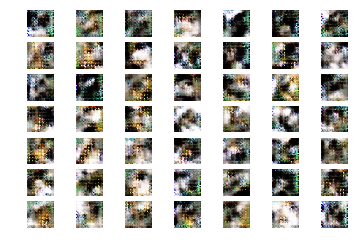

>9, 1/160, d1=0.508, d2=0.454 g=1.702
>9, 2/160, d1=0.648, d2=0.557 g=1.560
>9, 3/160, d1=0.559, d2=0.768 g=1.682
>9, 4/160, d1=0.640, d2=0.483 g=1.759
>9, 5/160, d1=0.671, d2=0.604 g=1.654
>9, 6/160, d1=0.596, d2=0.559 g=1.725
>9, 7/160, d1=0.606, d2=0.690 g=2.137
>9, 8/160, d1=0.657, d2=0.444 g=1.998
>9, 9/160, d1=0.631, d2=0.415 g=1.894
>9, 10/160, d1=0.563, d2=0.544 g=1.918
>9, 11/160, d1=0.515, d2=0.406 g=1.951
>9, 12/160, d1=0.587, d2=0.542 g=1.942
>9, 13/160, d1=0.432, d2=0.423 g=2.090
>9, 14/160, d1=0.606, d2=0.443 g=1.934
>9, 15/160, d1=0.543, d2=0.441 g=1.849
>9, 16/160, d1=0.605, d2=0.544 g=1.947
>9, 17/160, d1=0.549, d2=0.460 g=2.110
>9, 18/160, d1=0.483, d2=0.480 g=2.350
>9, 19/160, d1=0.644, d2=0.562 g=2.118
>9, 20/160, d1=0.608, d2=0.564 g=2.097
>9, 21/160, d1=0.649, d2=0.655 g=1.815
>9, 22/160, d1=0.746, d2=0.627 g=1.769
>9, 23/160, d1=0.831, d2=0.690 g=1.546
>9, 24/160, d1=0.810, d2=0.644 g=1.506
>9, 25/160, d1=0.717, d2=0.605 g=1.646
>9, 26/160, d1=0.660, d2=0.529 g=1

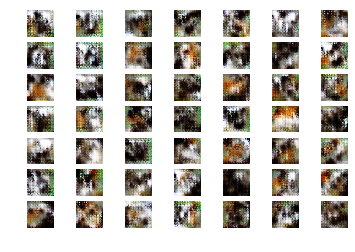

>10, 1/160, d1=0.494, d2=0.419 g=1.831
>10, 2/160, d1=0.423, d2=0.445 g=1.931
>10, 3/160, d1=0.506, d2=0.457 g=1.965
>10, 4/160, d1=0.431, d2=0.453 g=2.230
>10, 5/160, d1=0.552, d2=0.370 g=1.980
>10, 6/160, d1=0.530, d2=0.536 g=2.144
>10, 7/160, d1=0.487, d2=0.542 g=2.219
>10, 8/160, d1=0.727, d2=0.531 g=1.965
>10, 9/160, d1=0.520, d2=0.614 g=1.887
>10, 10/160, d1=0.658, d2=0.640 g=1.696
>10, 11/160, d1=0.717, d2=0.753 g=1.591
>10, 12/160, d1=0.646, d2=0.689 g=1.703
>10, 13/160, d1=0.748, d2=0.567 g=1.710
>10, 14/160, d1=0.673, d2=0.543 g=1.679
>10, 15/160, d1=0.628, d2=0.545 g=1.803
>10, 16/160, d1=0.569, d2=0.521 g=1.777
>10, 17/160, d1=0.527, d2=0.413 g=1.749
>10, 18/160, d1=0.568, d2=0.445 g=1.810
>10, 19/160, d1=0.479, d2=0.453 g=1.888
>10, 20/160, d1=0.399, d2=0.384 g=2.052
>10, 21/160, d1=0.294, d2=0.288 g=2.102
>10, 22/160, d1=0.366, d2=0.368 g=2.047
>10, 23/160, d1=0.340, d2=0.387 g=2.029
>10, 24/160, d1=0.377, d2=0.408 g=1.993
>10, 25/160, d1=0.374, d2=0.486 g=1.830
>10, 26/1

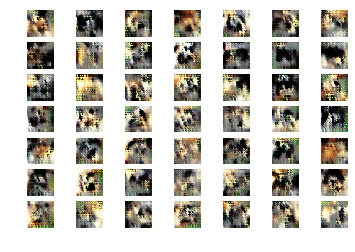

>11, 1/160, d1=0.413, d2=0.387 g=2.403
>11, 2/160, d1=0.439, d2=0.241 g=2.320
>11, 3/160, d1=0.383, d2=0.382 g=2.232
>11, 4/160, d1=0.396, d2=0.371 g=2.242
>11, 5/160, d1=0.411, d2=0.361 g=2.152
>11, 6/160, d1=0.378, d2=0.459 g=2.287
>11, 7/160, d1=0.554, d2=0.524 g=2.286
>11, 8/160, d1=0.538, d2=0.412 g=2.188
>11, 9/160, d1=0.511, d2=0.499 g=2.269
>11, 10/160, d1=0.667, d2=0.451 g=2.257
>11, 11/160, d1=0.728, d2=0.456 g=1.970
>11, 12/160, d1=0.575, d2=0.576 g=2.281
>11, 13/160, d1=0.450, d2=0.347 g=2.535
>11, 14/160, d1=0.621, d2=0.460 g=2.480
>11, 15/160, d1=0.537, d2=0.462 g=2.313
>11, 16/160, d1=0.357, d2=0.446 g=2.709
>11, 17/160, d1=0.637, d2=0.463 g=2.409
>11, 18/160, d1=0.530, d2=0.580 g=2.461
>11, 19/160, d1=0.707, d2=0.603 g=2.280
>11, 20/160, d1=0.674, d2=0.679 g=2.266
>11, 21/160, d1=0.861, d2=0.700 g=1.947
>11, 22/160, d1=0.698, d2=0.710 g=1.798
>11, 23/160, d1=0.682, d2=0.611 g=1.890
>11, 24/160, d1=0.671, d2=0.632 g=2.019
>11, 25/160, d1=0.766, d2=0.473 g=1.730
>11, 26/1

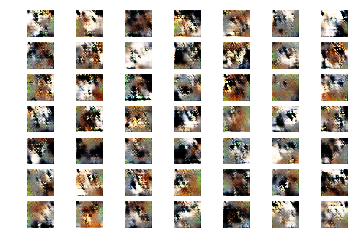

>12, 1/160, d1=0.479, d2=0.463 g=2.214
>12, 2/160, d1=0.466, d2=0.343 g=2.299
>12, 3/160, d1=0.511, d2=0.387 g=2.236
>12, 4/160, d1=0.429, d2=0.459 g=2.589
>12, 5/160, d1=0.432, d2=0.242 g=2.352
>12, 6/160, d1=0.442, d2=0.465 g=2.078
>12, 7/160, d1=0.412, d2=0.472 g=2.213
>12, 8/160, d1=0.570, d2=0.484 g=2.142
>12, 9/160, d1=0.656, d2=0.542 g=1.902
>12, 10/160, d1=0.604, d2=0.747 g=1.878
>12, 11/160, d1=0.645, d2=0.521 g=1.787
>12, 12/160, d1=0.693, d2=0.792 g=1.861
>12, 13/160, d1=0.752, d2=0.563 g=1.694
>12, 14/160, d1=0.657, d2=0.582 g=1.642
>12, 15/160, d1=0.617, d2=0.555 g=1.781
>12, 16/160, d1=0.610, d2=0.431 g=1.829
>12, 17/160, d1=0.556, d2=0.462 g=1.794
>12, 18/160, d1=0.452, d2=0.448 g=2.041
>12, 19/160, d1=0.655, d2=0.447 g=2.032
>12, 20/160, d1=0.482, d2=0.458 g=2.186
>12, 21/160, d1=0.473, d2=0.365 g=2.257
>12, 22/160, d1=0.521, d2=0.420 g=2.282
>12, 23/160, d1=0.452, d2=0.318 g=2.286
>12, 24/160, d1=0.445, d2=0.405 g=2.258
>12, 25/160, d1=0.528, d2=0.385 g=2.238
>12, 26/1

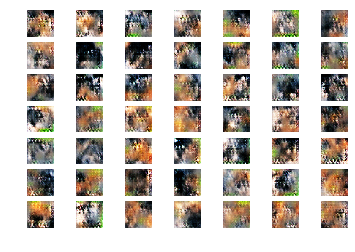

>13, 1/160, d1=0.567, d2=0.677 g=1.857
>13, 2/160, d1=0.668, d2=0.494 g=1.687
>13, 3/160, d1=0.643, d2=0.617 g=1.695
>13, 4/160, d1=0.563, d2=0.632 g=1.798
>13, 5/160, d1=0.590, d2=0.407 g=1.874
>13, 6/160, d1=0.468, d2=0.422 g=1.864
>13, 7/160, d1=0.463, d2=0.392 g=1.990
>13, 8/160, d1=0.531, d2=0.346 g=1.841
>13, 9/160, d1=0.374, d2=0.384 g=1.906
>13, 10/160, d1=0.299, d2=0.388 g=2.124
>13, 11/160, d1=0.384, d2=0.286 g=1.943
>13, 12/160, d1=0.446, d2=0.432 g=1.722
>13, 13/160, d1=0.312, d2=0.439 g=1.881
>13, 14/160, d1=0.353, d2=0.341 g=2.010
>13, 15/160, d1=0.421, d2=0.323 g=1.682
>13, 16/160, d1=0.376, d2=0.461 g=1.771
>13, 17/160, d1=0.363, d2=0.407 g=1.876
>13, 18/160, d1=0.353, d2=0.389 g=1.936
>13, 19/160, d1=0.387, d2=0.370 g=1.771
>13, 20/160, d1=0.250, d2=0.390 g=1.810
>13, 21/160, d1=0.351, d2=0.378 g=1.800
>13, 22/160, d1=0.435, d2=0.439 g=1.724
>13, 23/160, d1=0.466, d2=0.542 g=1.748
>13, 24/160, d1=0.605, d2=0.656 g=1.710
>13, 25/160, d1=0.420, d2=0.433 g=1.770
>13, 26/1

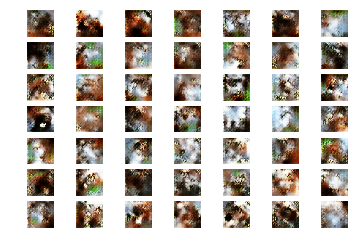

>14, 1/160, d1=0.393, d2=0.390 g=2.005
>14, 2/160, d1=0.352, d2=0.399 g=2.103
>14, 3/160, d1=0.406, d2=0.356 g=1.899
>14, 4/160, d1=0.435, d2=0.402 g=1.967
>14, 5/160, d1=0.403, d2=0.466 g=2.026
>14, 6/160, d1=0.499, d2=0.474 g=2.123
>14, 7/160, d1=0.384, d2=0.391 g=2.215
>14, 8/160, d1=0.406, d2=0.479 g=2.443
>14, 9/160, d1=0.575, d2=0.436 g=2.168
>14, 10/160, d1=0.527, d2=0.779 g=2.786
>14, 11/160, d1=0.868, d2=0.451 g=2.430
>14, 12/160, d1=0.703, d2=0.459 g=2.365
>14, 13/160, d1=0.584, d2=0.539 g=2.350
>14, 14/160, d1=0.428, d2=0.377 g=2.280
>14, 15/160, d1=0.468, d2=0.529 g=2.231
>14, 16/160, d1=0.524, d2=0.553 g=2.251
>14, 17/160, d1=0.711, d2=0.617 g=2.028
>14, 18/160, d1=0.556, d2=0.564 g=2.027
>14, 19/160, d1=0.504, d2=0.554 g=2.144
>14, 20/160, d1=0.592, d2=0.443 g=1.997
>14, 21/160, d1=0.544, d2=0.492 g=1.909
>14, 22/160, d1=0.610, d2=0.699 g=1.949
>14, 23/160, d1=0.751, d2=0.777 g=2.148
>14, 24/160, d1=0.794, d2=0.583 g=1.959
>14, 25/160, d1=0.918, d2=0.912 g=1.979
>14, 26/1

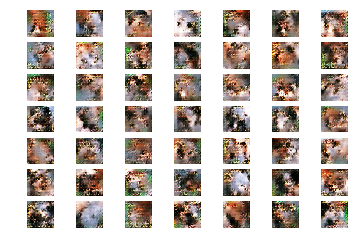

>15, 1/160, d1=0.605, d2=0.462 g=1.956
>15, 2/160, d1=0.644, d2=0.414 g=1.808
>15, 3/160, d1=0.526, d2=0.552 g=1.915
>15, 4/160, d1=0.643, d2=0.346 g=1.937
>15, 5/160, d1=0.490, d2=0.469 g=1.924
>15, 6/160, d1=0.625, d2=0.409 g=1.826
>15, 7/160, d1=0.471, d2=0.530 g=1.847
>15, 8/160, d1=0.644, d2=0.484 g=1.716
>15, 9/160, d1=0.434, d2=0.579 g=1.897
>15, 10/160, d1=0.580, d2=0.431 g=1.807
>15, 11/160, d1=0.595, d2=0.540 g=1.868
>15, 12/160, d1=0.526, d2=0.569 g=2.006
>15, 13/160, d1=0.761, d2=0.454 g=1.850
>15, 14/160, d1=0.491, d2=0.470 g=1.971
>15, 15/160, d1=0.530, d2=0.427 g=2.098
>15, 16/160, d1=0.477, d2=0.413 g=2.110
>15, 17/160, d1=0.569, d2=0.486 g=2.052
>15, 18/160, d1=0.483, d2=0.496 g=2.140
>15, 19/160, d1=0.509, d2=0.359 g=2.027
>15, 20/160, d1=0.697, d2=0.527 g=1.896
>15, 21/160, d1=0.624, d2=0.525 g=1.956
>15, 22/160, d1=0.594, d2=0.540 g=2.218
>15, 23/160, d1=0.511, d2=0.352 g=2.329
>15, 24/160, d1=0.601, d2=0.396 g=2.154
>15, 25/160, d1=0.435, d2=0.396 g=1.989
>15, 26/1

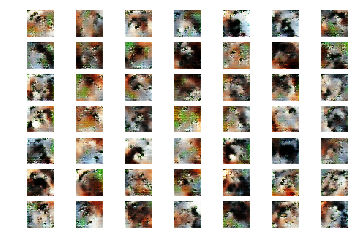

>16, 1/160, d1=0.380, d2=0.457 g=1.824
>16, 2/160, d1=0.468, d2=0.432 g=1.657
>16, 3/160, d1=0.303, d2=0.445 g=1.824
>16, 4/160, d1=0.477, d2=0.405 g=1.809
>16, 5/160, d1=0.417, d2=0.366 g=1.742
>16, 6/160, d1=0.364, d2=0.414 g=1.715
>16, 7/160, d1=0.294, d2=0.433 g=1.835
>16, 8/160, d1=0.337, d2=0.312 g=1.855
>16, 9/160, d1=0.363, d2=0.391 g=1.827
>16, 10/160, d1=0.349, d2=0.481 g=1.826
>16, 11/160, d1=0.365, d2=0.458 g=1.721
>16, 12/160, d1=0.488, d2=0.537 g=1.804
>16, 13/160, d1=0.653, d2=0.578 g=1.847
>16, 14/160, d1=0.740, d2=0.534 g=1.752
>16, 15/160, d1=0.718, d2=0.714 g=1.936
>16, 16/160, d1=0.865, d2=0.534 g=2.030
>16, 17/160, d1=0.710, d2=0.553 g=1.964
>16, 18/160, d1=0.766, d2=0.536 g=1.787
>16, 19/160, d1=0.558, d2=0.478 g=1.761
>16, 20/160, d1=0.658, d2=0.464 g=1.744
>16, 21/160, d1=0.417, d2=0.502 g=1.919
>16, 22/160, d1=0.562, d2=0.426 g=2.004
>16, 23/160, d1=0.485, d2=0.435 g=2.101
>16, 24/160, d1=0.621, d2=0.334 g=1.823
>16, 25/160, d1=0.450, d2=0.448 g=1.844
>16, 26/1

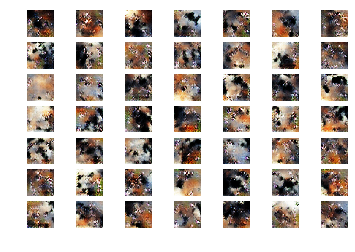

>17, 1/160, d1=0.456, d2=0.580 g=1.881
>17, 2/160, d1=0.500, d2=0.404 g=1.754
>17, 3/160, d1=0.501, d2=0.452 g=1.746
>17, 4/160, d1=0.430, d2=0.502 g=1.821
>17, 5/160, d1=0.536, d2=0.450 g=1.806
>17, 6/160, d1=0.529, d2=0.500 g=1.827
>17, 7/160, d1=0.519, d2=0.431 g=1.840
>17, 8/160, d1=0.487, d2=0.514 g=1.788
>17, 9/160, d1=0.553, d2=0.427 g=1.916
>17, 10/160, d1=0.621, d2=0.504 g=1.769
>17, 11/160, d1=0.354, d2=0.451 g=1.890
>17, 12/160, d1=0.482, d2=0.388 g=1.798
>17, 13/160, d1=0.424, d2=0.440 g=1.834
>17, 14/160, d1=0.374, d2=0.377 g=2.000
>17, 15/160, d1=0.321, d2=0.350 g=1.965
>17, 16/160, d1=0.423, d2=0.382 g=1.885
>17, 17/160, d1=0.301, d2=0.440 g=2.116
>17, 18/160, d1=0.489, d2=0.420 g=1.968
>17, 19/160, d1=0.391, d2=0.463 g=1.944
>17, 20/160, d1=0.478, d2=0.546 g=2.024
>17, 21/160, d1=0.555, d2=0.629 g=2.277
>17, 22/160, d1=0.764, d2=0.478 g=2.069
>17, 23/160, d1=0.817, d2=0.630 g=2.086
>17, 24/160, d1=0.602, d2=0.462 g=2.164
>17, 25/160, d1=0.745, d2=0.504 g=1.997
>17, 26/1

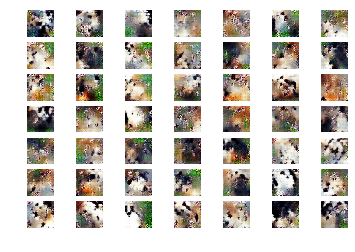

>18, 1/160, d1=0.708, d2=0.467 g=1.594
>18, 2/160, d1=0.480, d2=0.538 g=1.779
>18, 3/160, d1=0.421, d2=0.407 g=1.829
>18, 4/160, d1=0.514, d2=0.399 g=1.785
>18, 5/160, d1=0.416, d2=0.509 g=1.945
>18, 6/160, d1=0.410, d2=0.387 g=2.037
>18, 7/160, d1=0.472, d2=0.460 g=1.963
>18, 8/160, d1=0.439, d2=0.383 g=1.860
>18, 9/160, d1=0.504, d2=0.558 g=1.814
>18, 10/160, d1=0.551, d2=0.486 g=1.812
>18, 11/160, d1=0.524, d2=0.687 g=1.839
>18, 12/160, d1=0.523, d2=0.534 g=1.708
>18, 13/160, d1=0.709, d2=0.587 g=1.846
>18, 14/160, d1=0.661, d2=0.556 g=1.762
>18, 15/160, d1=0.693, d2=0.585 g=1.645
>18, 16/160, d1=0.613, d2=0.585 g=1.718
>18, 17/160, d1=0.737, d2=0.539 g=1.618
>18, 18/160, d1=0.587, d2=0.519 g=1.535
>18, 19/160, d1=0.529, d2=0.514 g=1.550
>18, 20/160, d1=0.537, d2=0.550 g=1.768
>18, 21/160, d1=0.557, d2=0.515 g=1.799
>18, 22/160, d1=0.585, d2=0.479 g=1.781
>18, 23/160, d1=0.518, d2=0.507 g=1.808
>18, 24/160, d1=0.548, d2=0.399 g=1.910
>18, 25/160, d1=0.526, d2=0.473 g=1.905
>18, 26/1

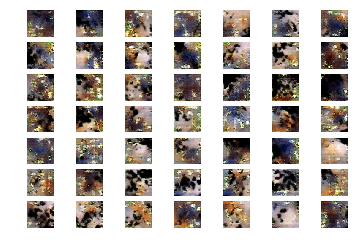

>19, 1/160, d1=0.502, d2=0.490 g=2.247
>19, 2/160, d1=0.644, d2=0.434 g=2.067
>19, 3/160, d1=0.740, d2=0.438 g=1.832
>19, 4/160, d1=0.472, d2=0.537 g=2.064
>19, 5/160, d1=0.647, d2=0.372 g=1.915
>19, 6/160, d1=0.564, d2=0.453 g=2.043
>19, 7/160, d1=0.651, d2=0.485 g=2.019
>19, 8/160, d1=0.692, d2=0.402 g=1.938
>19, 9/160, d1=0.469, d2=0.469 g=2.066
>19, 10/160, d1=0.619, d2=0.485 g=1.944
>19, 11/160, d1=0.637, d2=0.435 g=1.724
>19, 12/160, d1=0.525, d2=0.599 g=1.883
>19, 13/160, d1=0.615, d2=0.480 g=1.965
>19, 14/160, d1=0.650, d2=0.502 g=1.795
>19, 15/160, d1=0.610, d2=0.510 g=1.613
>19, 16/160, d1=0.695, d2=0.591 g=1.561
>19, 17/160, d1=0.639, d2=0.694 g=1.734
>19, 18/160, d1=0.633, d2=0.477 g=1.820
>19, 19/160, d1=0.591, d2=0.430 g=1.667
>19, 20/160, d1=0.691, d2=0.542 g=1.705
>19, 21/160, d1=0.595, d2=0.533 g=1.935
>19, 22/160, d1=0.671, d2=0.409 g=1.956
>19, 23/160, d1=0.530, d2=0.453 g=2.025
>19, 24/160, d1=0.584, d2=0.513 g=1.896
>19, 25/160, d1=0.477, d2=0.479 g=2.077
>19, 26/1

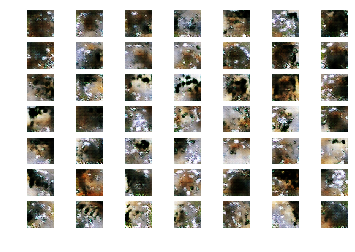

>20, 1/160, d1=0.414, d2=0.463 g=2.026
>20, 2/160, d1=0.525, d2=0.512 g=2.130
>20, 3/160, d1=0.579, d2=0.385 g=1.857
>20, 4/160, d1=0.462, d2=0.510 g=1.729
>20, 5/160, d1=0.572, d2=0.521 g=1.629
>20, 6/160, d1=0.505, d2=0.531 g=1.674
>20, 7/160, d1=0.466, d2=0.404 g=1.656
>20, 8/160, d1=0.516, d2=0.534 g=1.797
>20, 9/160, d1=0.513, d2=0.540 g=1.890
>20, 10/160, d1=0.608, d2=0.420 g=1.691
>20, 11/160, d1=0.594, d2=0.729 g=1.956
>20, 12/160, d1=0.635, d2=0.389 g=2.111
>20, 13/160, d1=0.669, d2=0.460 g=1.906
>20, 14/160, d1=0.700, d2=0.533 g=2.115
>20, 15/160, d1=0.610, d2=0.426 g=2.340
>20, 16/160, d1=0.538, d2=0.303 g=2.183
>20, 17/160, d1=0.393, d2=0.444 g=2.301
>20, 18/160, d1=0.448, d2=0.391 g=2.077
>20, 19/160, d1=0.458, d2=0.485 g=2.214
>20, 20/160, d1=0.588, d2=0.331 g=1.905
>20, 21/160, d1=0.426, d2=0.454 g=1.747
>20, 22/160, d1=0.449, d2=0.510 g=1.780
>20, 23/160, d1=0.513, d2=0.821 g=1.845
>20, 24/160, d1=0.680, d2=0.896 g=2.206
>20, 25/160, d1=0.804, d2=0.625 g=2.192
>20, 26/1

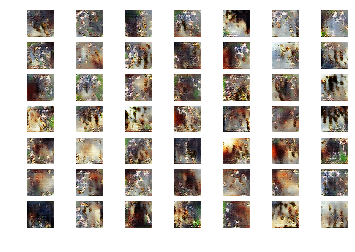

>21, 1/160, d1=0.570, d2=0.377 g=1.767
>21, 2/160, d1=0.381, d2=0.541 g=2.040
>21, 3/160, d1=0.480, d2=0.330 g=2.220
>21, 4/160, d1=0.688, d2=0.359 g=1.867
>21, 5/160, d1=0.448, d2=0.597 g=1.998
>21, 6/160, d1=0.466, d2=0.319 g=2.131
>21, 7/160, d1=0.467, d2=0.493 g=1.995
>21, 8/160, d1=0.522, d2=0.434 g=1.858
>21, 9/160, d1=0.579, d2=0.473 g=1.933
>21, 10/160, d1=0.451, d2=0.425 g=1.871
>21, 11/160, d1=0.519, d2=0.393 g=1.877
>21, 12/160, d1=0.495, d2=0.390 g=1.707
>21, 13/160, d1=0.364, d2=0.401 g=1.720
>21, 14/160, d1=0.392, d2=0.474 g=1.895
>21, 15/160, d1=0.422, d2=0.355 g=1.868
>21, 16/160, d1=0.411, d2=0.452 g=1.879
>21, 17/160, d1=0.406, d2=0.430 g=1.824
>21, 18/160, d1=0.556, d2=0.439 g=1.740
>21, 19/160, d1=0.537, d2=0.482 g=1.626
>21, 20/160, d1=0.358, d2=0.492 g=1.876
>21, 21/160, d1=0.410, d2=0.351 g=1.969
>21, 22/160, d1=0.470, d2=0.438 g=2.020
>21, 23/160, d1=0.584, d2=0.499 g=2.010
>21, 24/160, d1=0.613, d2=0.424 g=1.962
>21, 25/160, d1=0.543, d2=0.449 g=1.836
>21, 26/1

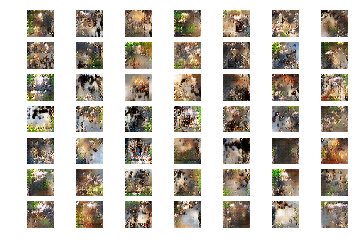

>22, 1/160, d1=0.678, d2=0.486 g=1.786
>22, 2/160, d1=0.695, d2=0.533 g=1.651
>22, 3/160, d1=0.676, d2=0.572 g=1.837
>22, 4/160, d1=0.425, d2=0.380 g=2.245
>22, 5/160, d1=0.504, d2=0.239 g=2.170
>22, 6/160, d1=0.366, d2=0.365 g=2.026
>22, 7/160, d1=0.293, d2=0.440 g=2.232
>22, 8/160, d1=0.288, d2=0.474 g=2.744
>22, 9/160, d1=0.453, d2=0.212 g=2.287
>22, 10/160, d1=0.380, d2=0.468 g=2.101
>22, 11/160, d1=0.553, d2=0.646 g=2.144
>22, 12/160, d1=0.549, d2=0.372 g=1.964
>22, 13/160, d1=0.473, d2=0.742 g=2.301
>22, 14/160, d1=0.668, d2=0.320 g=2.355
>22, 15/160, d1=0.642, d2=0.339 g=2.363
>22, 16/160, d1=0.615, d2=0.378 g=2.228
>22, 17/160, d1=0.579, d2=0.479 g=2.669
>22, 18/160, d1=0.630, d2=0.251 g=2.558
>22, 19/160, d1=0.531, d2=0.409 g=2.042
>22, 20/160, d1=0.542, d2=0.786 g=2.426
>22, 21/160, d1=0.602, d2=0.275 g=2.583
>22, 22/160, d1=0.356, d2=0.197 g=3.044
>22, 23/160, d1=0.433, d2=0.213 g=2.649
>22, 24/160, d1=0.270, d2=0.253 g=2.425
>22, 25/160, d1=0.259, d2=0.302 g=2.402
>22, 26/1

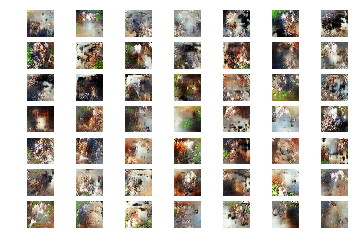

>23, 1/160, d1=0.532, d2=0.222 g=1.896
>23, 2/160, d1=0.484, d2=0.478 g=2.009
>23, 3/160, d1=0.545, d2=0.410 g=1.826
>23, 4/160, d1=0.515, d2=0.439 g=1.830
>23, 5/160, d1=0.384, d2=0.389 g=1.804
>23, 6/160, d1=0.366, d2=0.372 g=1.781
>23, 7/160, d1=0.417, d2=0.408 g=1.647
>23, 8/160, d1=0.370, d2=0.509 g=1.723
>23, 9/160, d1=0.276, d2=0.415 g=1.857
>23, 10/160, d1=0.440, d2=0.453 g=1.790
>23, 11/160, d1=0.422, d2=0.415 g=1.756
>23, 12/160, d1=0.496, d2=0.473 g=1.648
>23, 13/160, d1=0.429, d2=0.491 g=1.897
>23, 14/160, d1=0.605, d2=0.440 g=1.786
>23, 15/160, d1=0.620, d2=0.527 g=1.806
>23, 16/160, d1=0.403, d2=0.350 g=1.937
>23, 17/160, d1=0.601, d2=0.423 g=1.733
>23, 18/160, d1=0.317, d2=0.455 g=2.191
>23, 19/160, d1=0.568, d2=0.291 g=2.017
>23, 20/160, d1=0.418, d2=0.409 g=1.936
>23, 21/160, d1=0.472, d2=0.340 g=1.821
>23, 22/160, d1=0.372, d2=0.440 g=1.889
>23, 23/160, d1=0.424, d2=0.357 g=1.882
>23, 24/160, d1=0.417, d2=0.428 g=1.947
>23, 25/160, d1=0.411, d2=0.336 g=1.939
>23, 26/1

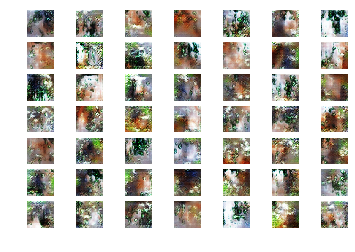

>24, 1/160, d1=0.645, d2=0.439 g=2.315
>24, 2/160, d1=0.622, d2=0.481 g=1.976
>24, 3/160, d1=0.643, d2=0.475 g=2.093
>24, 4/160, d1=0.629, d2=0.436 g=2.055
>24, 5/160, d1=0.622, d2=0.526 g=2.115
>24, 6/160, d1=0.656, d2=0.364 g=2.004
>24, 7/160, d1=0.504, d2=0.445 g=1.984
>24, 8/160, d1=0.490, d2=0.400 g=1.996
>24, 9/160, d1=0.480, d2=0.448 g=2.004
>24, 10/160, d1=0.545, d2=0.514 g=1.978
>24, 11/160, d1=0.522, d2=0.452 g=1.875
>24, 12/160, d1=0.456, d2=0.437 g=1.922
>24, 13/160, d1=0.658, d2=0.478 g=1.814
>24, 14/160, d1=0.545, d2=0.408 g=1.770
>24, 15/160, d1=0.367, d2=0.483 g=2.004
>24, 16/160, d1=0.491, d2=0.360 g=1.922
>24, 17/160, d1=0.590, d2=0.443 g=1.843
>24, 18/160, d1=0.365, d2=0.407 g=1.947
>24, 19/160, d1=0.530, d2=0.424 g=1.883
>24, 20/160, d1=0.476, d2=0.491 g=1.947
>24, 21/160, d1=0.502, d2=0.480 g=2.008
>24, 22/160, d1=0.383, d2=0.360 g=2.109
>24, 23/160, d1=0.759, d2=0.472 g=1.873
>24, 24/160, d1=0.437, d2=0.343 g=1.841
>24, 25/160, d1=0.580, d2=0.535 g=1.993
>24, 26/1

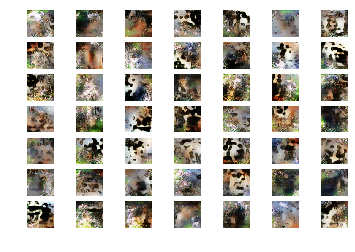

>25, 1/160, d1=0.772, d2=0.672 g=1.639
>25, 2/160, d1=0.684, d2=0.574 g=1.710
>25, 3/160, d1=0.738, d2=0.451 g=1.738
>25, 4/160, d1=0.802, d2=0.510 g=1.520
>25, 5/160, d1=0.678, d2=0.561 g=1.445
>25, 6/160, d1=0.661, d2=0.579 g=1.449
>25, 7/160, d1=0.597, d2=0.453 g=1.572
>25, 8/160, d1=0.655, d2=0.464 g=1.396
>25, 9/160, d1=0.618, d2=0.598 g=1.652
>25, 10/160, d1=0.735, d2=0.348 g=1.870
>25, 11/160, d1=0.589, d2=0.365 g=1.692
>25, 12/160, d1=0.410, d2=0.391 g=1.712
>25, 13/160, d1=0.395, d2=0.431 g=1.755
>25, 14/160, d1=0.464, d2=0.352 g=1.518
>25, 15/160, d1=0.526, d2=0.588 g=1.397
>25, 16/160, d1=0.435, d2=0.435 g=1.371
>25, 17/160, d1=0.405, d2=0.575 g=1.491
>25, 18/160, d1=0.502, d2=0.485 g=1.432
>25, 19/160, d1=0.564, d2=0.452 g=1.327
>25, 20/160, d1=0.505, d2=0.732 g=1.230
>25, 21/160, d1=0.627, d2=0.612 g=1.209
>25, 22/160, d1=0.629, d2=0.563 g=1.202
>25, 23/160, d1=0.479, d2=0.607 g=1.306
>25, 24/160, d1=0.479, d2=0.520 g=1.397
>25, 25/160, d1=0.719, d2=0.690 g=1.299
>25, 26/1

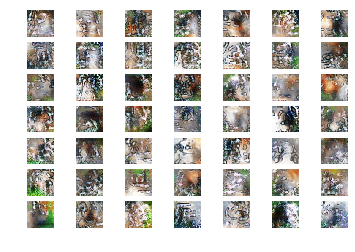

>26, 1/160, d1=0.566, d2=0.547 g=1.453
>26, 2/160, d1=0.631, d2=0.500 g=1.438
>26, 3/160, d1=0.638, d2=0.622 g=1.419
>26, 4/160, d1=0.643, d2=0.450 g=1.331
>26, 5/160, d1=0.424, d2=0.612 g=1.508
>26, 6/160, d1=0.561, d2=0.488 g=1.496
>26, 7/160, d1=0.677, d2=0.484 g=1.281
>26, 8/160, d1=0.518, d2=0.659 g=1.309
>26, 9/160, d1=0.788, d2=0.603 g=1.347
>26, 10/160, d1=0.671, d2=0.663 g=1.258
>26, 11/160, d1=0.541, d2=0.577 g=1.256
>26, 12/160, d1=0.715, d2=0.514 g=1.359
>26, 13/160, d1=0.565, d2=0.547 g=1.308
>26, 14/160, d1=0.543, d2=0.486 g=1.353
>26, 15/160, d1=0.593, d2=0.471 g=1.336
>26, 16/160, d1=0.549, d2=0.520 g=1.328
>26, 17/160, d1=0.518, d2=0.578 g=1.255
>26, 18/160, d1=0.608, d2=0.590 g=1.242
>26, 19/160, d1=0.597, d2=0.641 g=1.287
>26, 20/160, d1=0.580, d2=0.722 g=1.477
>26, 21/160, d1=0.629, d2=0.522 g=1.569
>26, 22/160, d1=0.703, d2=0.511 g=1.536
>26, 23/160, d1=0.759, d2=0.561 g=1.475
>26, 24/160, d1=0.749, d2=0.474 g=1.415
>26, 25/160, d1=0.613, d2=0.452 g=1.528
>26, 26/1

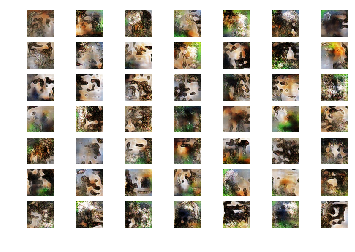

>27, 1/160, d1=0.742, d2=0.444 g=1.325
>27, 2/160, d1=0.647, d2=0.536 g=1.187
>27, 3/160, d1=0.619, d2=0.549 g=1.167
>27, 4/160, d1=0.574, d2=0.552 g=1.092
>27, 5/160, d1=0.474, d2=0.628 g=1.148
>27, 6/160, d1=0.548, d2=0.470 g=1.154
>27, 7/160, d1=0.601, d2=0.545 g=1.189
>27, 8/160, d1=0.562, d2=0.640 g=1.165
>27, 9/160, d1=0.544, d2=0.575 g=1.253
>27, 10/160, d1=0.535, d2=0.535 g=1.254
>27, 11/160, d1=0.596, d2=0.480 g=1.296
>27, 12/160, d1=0.561, d2=0.493 g=1.244
>27, 13/160, d1=0.575, d2=0.514 g=1.189
>27, 14/160, d1=0.486, d2=0.580 g=1.307
>27, 15/160, d1=0.536, d2=0.426 g=1.278
>27, 16/160, d1=0.660, d2=0.562 g=1.168
>27, 17/160, d1=0.491, d2=0.646 g=1.255
>27, 18/160, d1=0.628, d2=0.523 g=1.219
>27, 19/160, d1=0.623, d2=0.532 g=1.185
>27, 20/160, d1=0.470, d2=0.493 g=1.298
>27, 21/160, d1=0.548, d2=0.525 g=1.309
>27, 22/160, d1=0.599, d2=0.600 g=1.443
>27, 23/160, d1=0.610, d2=0.546 g=1.468
>27, 24/160, d1=0.696, d2=0.920 g=1.929
>27, 25/160, d1=0.716, d2=0.311 g=1.704
>27, 26/1

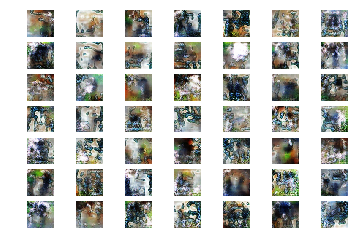

>28, 1/160, d1=0.624, d2=0.551 g=1.307
>28, 2/160, d1=0.517, d2=0.595 g=1.337
>28, 3/160, d1=0.649, d2=0.537 g=1.277
>28, 4/160, d1=0.573, d2=0.577 g=1.155
>28, 5/160, d1=0.608, d2=0.562 g=1.227
>28, 6/160, d1=0.646, d2=0.554 g=1.345
>28, 7/160, d1=0.447, d2=0.448 g=1.365
>28, 8/160, d1=0.581, d2=0.456 g=1.281
>28, 9/160, d1=0.522, d2=0.521 g=1.254
>28, 10/160, d1=0.460, d2=0.583 g=1.522
>28, 11/160, d1=0.554, d2=0.471 g=1.319
>28, 12/160, d1=0.510, d2=0.586 g=1.465
>28, 13/160, d1=0.409, d2=0.493 g=1.296
>28, 14/160, d1=0.594, d2=0.498 g=1.433
>28, 15/160, d1=0.573, d2=0.584 g=1.232
>28, 16/160, d1=0.654, d2=0.663 g=1.181
>28, 17/160, d1=0.554, d2=0.584 g=1.305
>28, 18/160, d1=0.653, d2=0.524 g=1.334
>28, 19/160, d1=0.689, d2=0.491 g=1.268
>28, 20/160, d1=0.573, d2=0.519 g=1.241
>28, 21/160, d1=0.542, d2=0.558 g=1.304
>28, 22/160, d1=0.513, d2=0.578 g=1.259
>28, 23/160, d1=0.516, d2=0.554 g=1.210
>28, 24/160, d1=0.597, d2=0.546 g=1.264
>28, 25/160, d1=0.575, d2=0.590 g=1.563
>28, 26/1

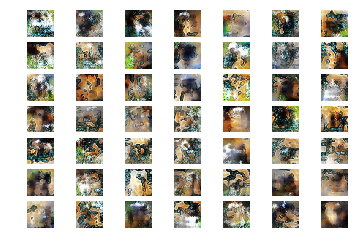

>29, 1/160, d1=0.544, d2=0.596 g=1.199
>29, 2/160, d1=0.547, d2=0.557 g=1.334
>29, 3/160, d1=0.533, d2=0.428 g=1.343
>29, 4/160, d1=0.484, d2=0.520 g=1.342
>29, 5/160, d1=0.508, d2=0.450 g=1.323
>29, 6/160, d1=0.534, d2=0.498 g=1.321
>29, 7/160, d1=0.552, d2=0.527 g=1.247
>29, 8/160, d1=0.440, d2=0.586 g=1.363
>29, 9/160, d1=0.653, d2=0.456 g=1.347
>29, 10/160, d1=0.687, d2=0.476 g=1.375
>29, 11/160, d1=0.476, d2=0.553 g=1.228
>29, 12/160, d1=0.643, d2=0.645 g=1.270
>29, 13/160, d1=0.540, d2=0.537 g=1.204
>29, 14/160, d1=0.586, d2=0.510 g=1.276
>29, 15/160, d1=0.489, d2=0.520 g=1.302
>29, 16/160, d1=0.538, d2=0.489 g=1.355
>29, 17/160, d1=0.485, d2=0.428 g=1.395
>29, 18/160, d1=0.532, d2=0.479 g=1.351
>29, 19/160, d1=0.478, d2=0.507 g=1.310
>29, 20/160, d1=0.452, d2=0.541 g=1.349
>29, 21/160, d1=0.522, d2=0.477 g=1.460
>29, 22/160, d1=0.783, d2=0.494 g=1.383
>29, 23/160, d1=0.672, d2=0.492 g=1.552
>29, 24/160, d1=0.692, d2=0.562 g=1.315
>29, 25/160, d1=0.466, d2=0.464 g=1.320
>29, 26/1

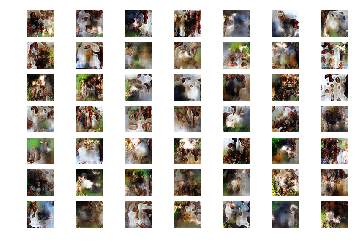

>30, 1/160, d1=0.613, d2=0.512 g=1.306
>30, 2/160, d1=0.473, d2=0.617 g=1.422
>30, 3/160, d1=0.509, d2=0.542 g=1.455
>30, 4/160, d1=0.660, d2=0.446 g=1.362
>30, 5/160, d1=0.523, d2=0.527 g=1.264
>30, 6/160, d1=0.591, d2=0.606 g=1.415
>30, 7/160, d1=0.562, d2=0.552 g=1.389
>30, 8/160, d1=0.596, d2=0.557 g=1.404
>30, 9/160, d1=0.699, d2=0.594 g=1.365
>30, 10/160, d1=0.721, d2=0.538 g=1.304
>30, 11/160, d1=0.600, d2=0.601 g=1.322
>30, 12/160, d1=0.630, d2=0.557 g=1.469
>30, 13/160, d1=0.568, d2=0.487 g=1.611
>30, 14/160, d1=0.722, d2=0.543 g=1.610
>30, 15/160, d1=0.539, d2=0.377 g=1.696
>30, 16/160, d1=0.462, d2=0.456 g=1.449
>30, 17/160, d1=0.465, d2=0.467 g=1.372
>30, 18/160, d1=0.435, d2=0.488 g=1.277
>30, 19/160, d1=0.569, d2=0.589 g=1.337
>30, 20/160, d1=0.446, d2=0.511 g=1.327
>30, 21/160, d1=0.762, d2=0.564 g=1.251
>30, 22/160, d1=0.591, d2=0.740 g=1.496
>30, 23/160, d1=0.651, d2=0.470 g=1.574
>30, 24/160, d1=0.720, d2=0.420 g=1.285
>30, 25/160, d1=0.622, d2=0.688 g=1.304
>30, 26/1

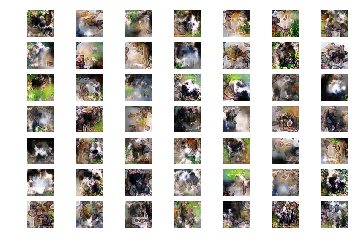

>31, 1/160, d1=0.512, d2=0.493 g=1.434
>31, 2/160, d1=0.452, d2=0.440 g=1.278
>31, 3/160, d1=0.627, d2=0.592 g=1.325
>31, 4/160, d1=0.674, d2=0.591 g=1.318
>31, 5/160, d1=0.594, d2=0.418 g=1.291
>31, 6/160, d1=0.490, d2=0.552 g=1.383
>31, 7/160, d1=0.561, d2=0.435 g=1.243
>31, 8/160, d1=0.419, d2=0.456 g=1.249
>31, 9/160, d1=0.425, d2=0.569 g=1.389
>31, 10/160, d1=0.620, d2=0.803 g=1.315
>31, 11/160, d1=0.701, d2=0.515 g=1.532
>31, 12/160, d1=0.677, d2=0.419 g=1.445
>31, 13/160, d1=0.544, d2=0.522 g=1.251
>31, 14/160, d1=0.488, d2=0.652 g=1.352
>31, 15/160, d1=0.619, d2=0.504 g=1.360
>31, 16/160, d1=0.677, d2=0.543 g=1.361
>31, 17/160, d1=0.640, d2=0.583 g=1.299
>31, 18/160, d1=0.561, d2=0.606 g=1.286
>31, 19/160, d1=0.560, d2=0.467 g=1.273
>31, 20/160, d1=0.618, d2=0.701 g=1.371
>31, 21/160, d1=0.629, d2=0.482 g=1.452
>31, 22/160, d1=0.531, d2=0.422 g=1.380
>31, 23/160, d1=0.557, d2=0.669 g=1.331
>31, 24/160, d1=0.500, d2=0.515 g=1.323
>31, 25/160, d1=0.618, d2=0.539 g=1.293
>31, 26/1

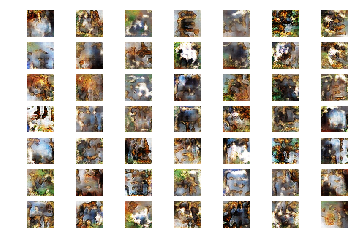

>32, 1/160, d1=0.620, d2=0.487 g=1.264
>32, 2/160, d1=0.480, d2=0.558 g=1.379
>32, 3/160, d1=0.485, d2=0.610 g=1.398
>32, 4/160, d1=0.604, d2=0.526 g=1.464
>32, 5/160, d1=0.645, d2=0.536 g=1.403
>32, 6/160, d1=0.653, d2=0.551 g=1.455
>32, 7/160, d1=0.536, d2=0.509 g=1.556
>32, 8/160, d1=0.700, d2=0.494 g=1.366
>32, 9/160, d1=0.551, d2=0.672 g=1.312
>32, 10/160, d1=0.519, d2=0.589 g=1.370
>32, 11/160, d1=0.528, d2=0.432 g=1.447
>32, 12/160, d1=0.645, d2=0.470 g=1.351
>32, 13/160, d1=0.642, d2=0.542 g=1.291
>32, 14/160, d1=0.582, d2=0.545 g=1.298
>32, 15/160, d1=0.618, d2=0.494 g=1.217
>32, 16/160, d1=0.546, d2=0.541 g=1.258
>32, 17/160, d1=0.526, d2=0.563 g=1.260
>32, 18/160, d1=0.599, d2=0.582 g=1.344
>32, 19/160, d1=0.542, d2=0.482 g=1.358
>32, 20/160, d1=0.620, d2=0.484 g=1.236
>32, 21/160, d1=0.553, d2=0.571 g=1.204
>32, 22/160, d1=0.526, d2=0.568 g=1.325
>32, 23/160, d1=0.535, d2=0.591 g=1.256
>32, 24/160, d1=0.677, d2=0.574 g=1.277
>32, 25/160, d1=0.624, d2=0.472 g=1.321
>32, 26/1

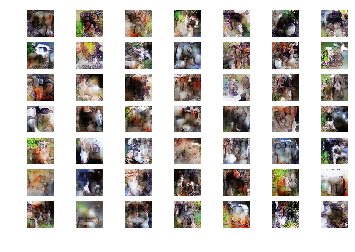

>33, 1/160, d1=0.607, d2=0.493 g=1.484
>33, 2/160, d1=0.616, d2=0.568 g=1.356
>33, 3/160, d1=0.604, d2=0.641 g=1.321
>33, 4/160, d1=0.660, d2=0.611 g=1.365
>33, 5/160, d1=0.708, d2=0.537 g=1.323
>33, 6/160, d1=0.746, d2=0.646 g=1.309
>33, 7/160, d1=0.628, d2=0.580 g=1.295
>33, 8/160, d1=0.546, d2=0.473 g=1.299
>33, 9/160, d1=0.610, d2=0.633 g=1.233
>33, 10/160, d1=0.548, d2=0.549 g=1.267
>33, 11/160, d1=0.607, d2=0.557 g=1.322
>33, 12/160, d1=0.621, d2=0.469 g=1.259
>33, 13/160, d1=0.526, d2=0.538 g=1.321
>33, 14/160, d1=0.530, d2=0.488 g=1.457
>33, 15/160, d1=0.553, d2=0.477 g=1.411
>33, 16/160, d1=0.428, d2=0.437 g=1.427
>33, 17/160, d1=0.556, d2=0.516 g=1.364
>33, 18/160, d1=0.542, d2=0.558 g=1.304
>33, 19/160, d1=0.565, d2=0.510 g=1.272
>33, 20/160, d1=0.544, d2=0.544 g=1.285
>33, 21/160, d1=0.534, d2=0.525 g=1.461
>33, 22/160, d1=0.663, d2=0.542 g=1.499
>33, 23/160, d1=0.677, d2=0.463 g=1.299
>33, 24/160, d1=0.604, d2=0.512 g=1.274
>33, 25/160, d1=0.627, d2=0.563 g=1.176
>33, 26/1

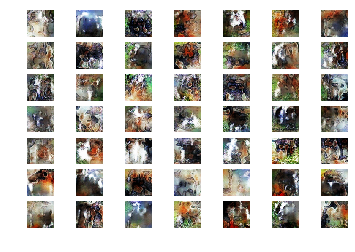

>34, 1/160, d1=0.498, d2=0.418 g=1.499
>34, 2/160, d1=0.627, d2=0.503 g=1.528
>34, 3/160, d1=0.516, d2=0.464 g=1.431
>34, 4/160, d1=0.452, d2=0.474 g=1.437
>34, 5/160, d1=0.593, d2=0.454 g=1.426
>34, 6/160, d1=0.563, d2=0.664 g=1.445
>34, 7/160, d1=0.503, d2=0.412 g=1.489
>34, 8/160, d1=0.570, d2=0.446 g=1.463
>34, 9/160, d1=0.619, d2=0.709 g=1.568
>34, 10/160, d1=0.588, d2=0.535 g=1.527
>34, 11/160, d1=0.688, d2=0.413 g=1.285
>34, 12/160, d1=0.396, d2=0.578 g=1.328
>34, 13/160, d1=0.412, d2=0.505 g=1.410
>34, 14/160, d1=0.450, d2=0.390 g=1.409
>34, 15/160, d1=0.563, d2=0.441 g=1.300
>34, 16/160, d1=0.553, d2=0.569 g=1.306
>34, 17/160, d1=0.449, d2=0.588 g=1.354
>34, 18/160, d1=0.630, d2=0.654 g=1.523
>34, 19/160, d1=0.565, d2=0.341 g=1.500
>34, 20/160, d1=0.671, d2=0.488 g=1.325
>34, 21/160, d1=0.434, d2=0.586 g=1.234
>34, 22/160, d1=0.543, d2=0.642 g=1.444
>34, 23/160, d1=0.607, d2=0.509 g=1.443
>34, 24/160, d1=0.713, d2=0.494 g=1.354
>34, 25/160, d1=0.714, d2=0.593 g=1.303
>34, 26/1

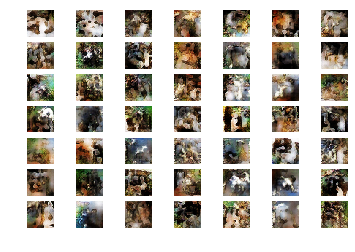

>35, 1/160, d1=0.560, d2=0.468 g=1.315
>35, 2/160, d1=0.484, d2=0.628 g=1.636
>35, 3/160, d1=0.628, d2=0.567 g=1.702
>35, 4/160, d1=0.728, d2=0.498 g=1.414
>35, 5/160, d1=0.531, d2=0.726 g=1.436
>35, 6/160, d1=0.619, d2=0.460 g=1.653
>35, 7/160, d1=0.534, d2=0.396 g=1.574
>35, 8/160, d1=0.628, d2=0.561 g=1.546
>35, 9/160, d1=0.471, d2=0.445 g=1.598
>35, 10/160, d1=0.421, d2=0.534 g=1.748
>35, 11/160, d1=0.397, d2=0.388 g=1.830
>35, 12/160, d1=0.527, d2=0.589 g=1.544
>35, 13/160, d1=0.486, d2=0.483 g=1.659
>35, 14/160, d1=0.531, d2=0.510 g=1.485
>35, 15/160, d1=0.562, d2=0.663 g=1.507
>35, 16/160, d1=0.671, d2=0.733 g=1.716
>35, 17/160, d1=0.819, d2=0.378 g=1.488
>35, 18/160, d1=0.685, d2=0.495 g=1.561
>35, 19/160, d1=0.641, d2=0.523 g=1.405
>35, 20/160, d1=0.446, d2=0.503 g=1.474
>35, 21/160, d1=0.469, d2=0.498 g=1.380
>35, 22/160, d1=0.580, d2=0.597 g=1.481
>35, 23/160, d1=0.570, d2=0.468 g=1.426
>35, 24/160, d1=0.624, d2=0.528 g=1.366
>35, 25/160, d1=0.625, d2=0.496 g=1.308
>35, 26/1

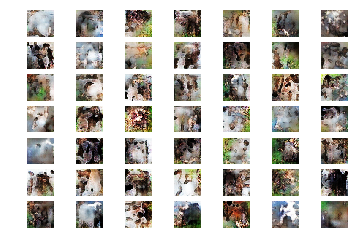

>36, 1/160, d1=0.554, d2=0.510 g=1.394
>36, 2/160, d1=0.639, d2=0.527 g=1.436
>36, 3/160, d1=0.627, d2=0.575 g=1.553
>36, 4/160, d1=0.632, d2=0.475 g=1.542
>36, 5/160, d1=0.592, d2=0.508 g=1.318
>36, 6/160, d1=0.594, d2=0.494 g=1.434
>36, 7/160, d1=0.529, d2=0.417 g=1.343
>36, 8/160, d1=0.513, d2=0.442 g=1.387
>36, 9/160, d1=0.531, d2=0.460 g=1.434
>36, 10/160, d1=0.514, d2=0.517 g=1.594
>36, 11/160, d1=0.587, d2=0.453 g=1.452
>36, 12/160, d1=0.629, d2=0.492 g=1.391
>36, 13/160, d1=0.636, d2=0.628 g=1.300
>36, 14/160, d1=0.622, d2=0.713 g=1.354
>36, 15/160, d1=0.587, d2=0.492 g=1.460
>36, 16/160, d1=0.589, d2=0.612 g=1.468
>36, 17/160, d1=0.635, d2=0.532 g=1.416
>36, 18/160, d1=0.686, d2=0.577 g=1.272
>36, 19/160, d1=0.537, d2=0.502 g=1.300
>36, 20/160, d1=0.585, d2=0.572 g=1.302
>36, 21/160, d1=0.534, d2=0.506 g=1.409
>36, 22/160, d1=0.580, d2=0.507 g=1.454
>36, 23/160, d1=0.653, d2=0.510 g=1.485
>36, 24/160, d1=0.659, d2=0.477 g=1.540
>36, 25/160, d1=0.581, d2=0.474 g=1.566
>36, 26/1

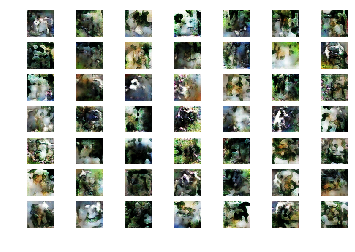

>37, 1/160, d1=0.530, d2=0.435 g=1.657
>37, 2/160, d1=0.680, d2=0.576 g=1.821
>37, 3/160, d1=0.529, d2=0.537 g=1.634
>37, 4/160, d1=0.645, d2=0.664 g=1.378
>37, 5/160, d1=0.647, d2=0.700 g=1.412
>37, 6/160, d1=0.620, d2=0.565 g=1.381
>37, 7/160, d1=0.652, d2=0.622 g=1.443
>37, 8/160, d1=0.561, d2=0.625 g=1.652
>37, 9/160, d1=0.759, d2=0.555 g=1.542
>37, 10/160, d1=0.528, d2=0.494 g=1.447
>37, 11/160, d1=0.529, d2=0.647 g=1.533
>37, 12/160, d1=0.506, d2=0.446 g=1.553
>37, 13/160, d1=0.639, d2=0.482 g=1.503
>37, 14/160, d1=0.491, d2=0.481 g=1.671
>37, 15/160, d1=0.538, d2=0.504 g=1.668
>37, 16/160, d1=0.520, d2=0.459 g=1.684
>37, 17/160, d1=0.515, d2=0.468 g=1.633
>37, 18/160, d1=0.435, d2=0.366 g=1.489
>37, 19/160, d1=0.341, d2=0.629 g=1.571
>37, 20/160, d1=0.543, d2=0.365 g=1.440
>37, 21/160, d1=0.489, d2=0.588 g=1.451
>37, 22/160, d1=0.667, d2=0.461 g=1.366
>37, 23/160, d1=0.482, d2=0.591 g=1.402
>37, 24/160, d1=0.504, d2=0.712 g=1.596
>37, 25/160, d1=0.712, d2=0.437 g=1.520
>37, 26/1

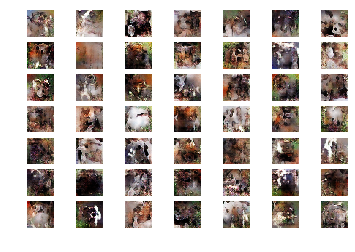

>38, 1/160, d1=0.510, d2=0.392 g=1.749
>38, 2/160, d1=0.661, d2=0.471 g=1.450
>38, 3/160, d1=0.461, d2=0.631 g=1.603
>38, 4/160, d1=0.603, d2=0.365 g=1.587
>38, 5/160, d1=0.694, d2=0.510 g=1.594
>38, 6/160, d1=0.546, d2=0.444 g=1.452
>38, 7/160, d1=0.536, d2=0.634 g=1.794
>38, 8/160, d1=0.672, d2=0.406 g=1.686
>38, 9/160, d1=0.655, d2=0.497 g=1.471
>38, 10/160, d1=0.531, d2=0.570 g=1.359
>38, 11/160, d1=0.430, d2=0.480 g=1.367
>38, 12/160, d1=0.457, d2=0.484 g=1.376
>38, 13/160, d1=0.462, d2=0.527 g=1.323
>38, 14/160, d1=0.592, d2=0.512 g=1.477
>38, 15/160, d1=0.518, d2=0.447 g=1.405
>38, 16/160, d1=0.539, d2=0.551 g=1.338
>38, 17/160, d1=0.535, d2=0.675 g=1.530
>38, 18/160, d1=0.606, d2=0.605 g=1.756
>38, 19/160, d1=0.681, d2=0.847 g=1.971
>38, 20/160, d1=0.924, d2=0.367 g=1.641
>38, 21/160, d1=0.686, d2=0.426 g=1.448
>38, 22/160, d1=0.675, d2=0.611 g=1.354
>38, 23/160, d1=0.464, d2=0.538 g=1.448
>38, 24/160, d1=0.578, d2=0.477 g=1.514
>38, 25/160, d1=0.651, d2=0.570 g=1.350
>38, 26/1

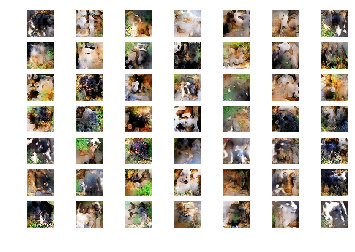

>39, 1/160, d1=0.699, d2=0.574 g=1.219
>39, 2/160, d1=0.542, d2=0.701 g=1.303
>39, 3/160, d1=0.562, d2=0.522 g=1.303
>39, 4/160, d1=0.640, d2=0.519 g=1.392
>39, 5/160, d1=0.513, d2=0.590 g=1.508
>39, 6/160, d1=0.646, d2=0.486 g=1.415
>39, 7/160, d1=0.520, d2=0.617 g=1.696
>39, 8/160, d1=0.638, d2=0.379 g=1.601
>39, 9/160, d1=0.473, d2=0.547 g=1.531
>39, 10/160, d1=0.503, d2=0.719 g=1.717
>39, 11/160, d1=0.730, d2=0.435 g=1.460
>39, 12/160, d1=0.568, d2=0.686 g=1.507
>39, 13/160, d1=0.688, d2=0.887 g=1.687
>39, 14/160, d1=0.961, d2=0.565 g=1.629
>39, 15/160, d1=0.927, d2=0.510 g=1.406
>39, 16/160, d1=0.727, d2=0.552 g=1.284
>39, 17/160, d1=0.647, d2=0.619 g=1.345
>39, 18/160, d1=0.511, d2=0.488 g=1.370
>39, 19/160, d1=0.548, d2=0.703 g=1.310
>39, 20/160, d1=0.696, d2=0.651 g=1.374
>39, 21/160, d1=0.467, d2=0.553 g=1.324
>39, 22/160, d1=0.582, d2=0.549 g=1.347
>39, 23/160, d1=0.566, d2=0.697 g=1.404
>39, 24/160, d1=0.627, d2=0.508 g=1.368
>39, 25/160, d1=0.552, d2=0.549 g=1.278
>39, 26/1

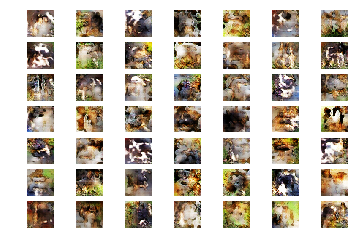

>40, 1/160, d1=0.738, d2=0.557 g=1.347
>40, 2/160, d1=0.598, d2=0.513 g=1.382
>40, 3/160, d1=0.522, d2=0.624 g=1.360
>40, 4/160, d1=0.651, d2=0.634 g=1.600
>40, 5/160, d1=0.762, d2=0.510 g=1.408
>40, 6/160, d1=0.566, d2=0.713 g=1.556
>40, 7/160, d1=0.650, d2=0.424 g=1.555
>40, 8/160, d1=0.722, d2=0.466 g=1.440
>40, 9/160, d1=0.549, d2=0.534 g=1.348
>40, 10/160, d1=0.422, d2=0.493 g=1.418
>40, 11/160, d1=0.547, d2=0.453 g=1.453
>40, 12/160, d1=0.508, d2=0.479 g=1.410
>40, 13/160, d1=0.573, d2=0.531 g=1.369
>40, 14/160, d1=0.512, d2=0.529 g=1.425
>40, 15/160, d1=0.542, d2=0.480 g=1.398
>40, 16/160, d1=0.459, d2=0.545 g=1.432
>40, 17/160, d1=0.589, d2=0.478 g=1.414
>40, 18/160, d1=0.564, d2=0.474 g=1.469
>40, 19/160, d1=0.599, d2=0.731 g=1.513
>40, 20/160, d1=0.602, d2=0.584 g=1.641
>40, 21/160, d1=0.687, d2=0.652 g=1.530
>40, 22/160, d1=0.764, d2=0.567 g=1.278
>40, 23/160, d1=0.592, d2=0.590 g=1.423
>40, 24/160, d1=0.576, d2=0.518 g=1.490
>40, 25/160, d1=0.753, d2=0.606 g=1.380
>40, 26/1

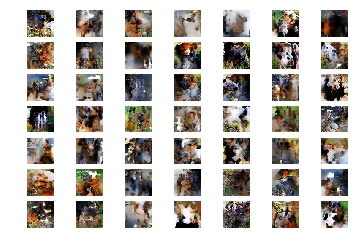

>41, 1/160, d1=0.660, d2=0.587 g=1.435
>41, 2/160, d1=0.531, d2=0.574 g=1.608
>41, 3/160, d1=0.590, d2=0.375 g=1.514
>41, 4/160, d1=0.690, d2=0.528 g=1.454
>41, 5/160, d1=0.647, d2=0.512 g=1.440
>41, 6/160, d1=0.473, d2=0.535 g=1.515
>41, 7/160, d1=0.609, d2=0.531 g=1.507
>41, 8/160, d1=0.661, d2=0.645 g=1.509
>41, 9/160, d1=0.654, d2=0.733 g=1.549
>41, 10/160, d1=0.591, d2=1.085 g=1.756
>41, 11/160, d1=0.904, d2=0.886 g=1.605
>41, 12/160, d1=0.918, d2=0.446 g=1.426
>41, 13/160, d1=0.787, d2=0.526 g=1.282
>41, 14/160, d1=0.704, d2=0.580 g=1.280
>41, 15/160, d1=0.577, d2=0.658 g=1.347
>41, 16/160, d1=0.585, d2=0.461 g=1.490
>41, 17/160, d1=0.580, d2=0.449 g=1.475
>41, 18/160, d1=0.435, d2=0.563 g=1.363
>41, 19/160, d1=0.468, d2=0.518 g=1.420
>41, 20/160, d1=0.498, d2=0.552 g=1.374
>41, 21/160, d1=0.483, d2=0.466 g=1.424
>41, 22/160, d1=0.505, d2=0.557 g=1.357
>41, 23/160, d1=0.431, d2=0.494 g=1.477
>41, 24/160, d1=0.556, d2=0.596 g=1.597
>41, 25/160, d1=0.526, d2=0.539 g=1.733
>41, 26/1

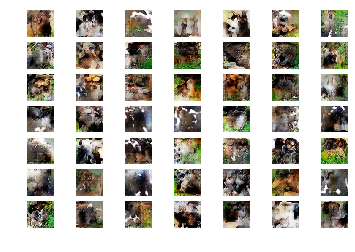

>42, 1/160, d1=0.903, d2=0.514 g=1.311
>42, 2/160, d1=0.617, d2=0.452 g=1.272
>42, 3/160, d1=0.638, d2=0.532 g=1.223
>42, 4/160, d1=0.589, d2=0.584 g=1.298
>42, 5/160, d1=0.570, d2=0.484 g=1.355
>42, 6/160, d1=0.466, d2=0.458 g=1.470
>42, 7/160, d1=0.493, d2=0.501 g=1.493
>42, 8/160, d1=0.513, d2=0.629 g=1.555
>42, 9/160, d1=0.553, d2=0.455 g=1.547
>42, 10/160, d1=0.561, d2=0.433 g=1.383
>42, 11/160, d1=0.520, d2=0.489 g=1.349
>42, 12/160, d1=0.557, d2=0.571 g=1.281
>42, 13/160, d1=0.499, d2=0.527 g=1.372
>42, 14/160, d1=0.461, d2=0.525 g=1.367
>42, 15/160, d1=0.614, d2=0.523 g=1.349
>42, 16/160, d1=0.462, d2=0.498 g=1.327
>42, 17/160, d1=0.604, d2=0.549 g=1.377
>42, 18/160, d1=0.506, d2=0.608 g=1.548
>42, 19/160, d1=0.562, d2=0.482 g=1.356
>42, 20/160, d1=0.628, d2=0.495 g=1.362
>42, 21/160, d1=0.652, d2=0.552 g=1.383
>42, 22/160, d1=0.534, d2=0.547 g=1.526
>42, 23/160, d1=0.512, d2=0.482 g=1.559
>42, 24/160, d1=0.566, d2=0.441 g=1.554
>42, 25/160, d1=0.612, d2=0.596 g=1.424
>42, 26/1

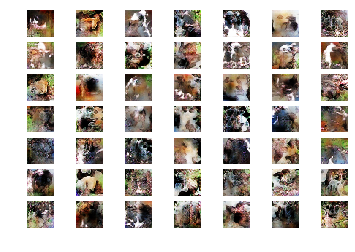

>43, 1/160, d1=0.666, d2=0.683 g=1.417
>43, 2/160, d1=0.798, d2=0.449 g=1.333
>43, 3/160, d1=0.681, d2=0.556 g=1.236
>43, 4/160, d1=0.686, d2=0.708 g=1.287
>43, 5/160, d1=0.697, d2=0.467 g=1.251
>43, 6/160, d1=0.649, d2=0.616 g=1.155
>43, 7/160, d1=0.450, d2=0.662 g=1.162
>43, 8/160, d1=0.646, d2=0.488 g=1.312
>43, 9/160, d1=0.617, d2=0.495 g=1.310
>43, 10/160, d1=0.490, d2=0.472 g=1.318
>43, 11/160, d1=0.517, d2=0.537 g=1.413
>43, 12/160, d1=0.529, d2=0.431 g=1.417
>43, 13/160, d1=0.528, d2=0.433 g=1.405
>43, 14/160, d1=0.595, d2=0.543 g=1.254
>43, 15/160, d1=0.466, d2=0.589 g=1.519
>43, 16/160, d1=0.565, d2=0.479 g=1.415
>43, 17/160, d1=0.598, d2=0.461 g=1.324
>43, 18/160, d1=0.575, d2=0.589 g=1.250
>43, 19/160, d1=0.593, d2=0.533 g=1.140
>43, 20/160, d1=0.503, d2=0.526 g=1.227
>43, 21/160, d1=0.504, d2=0.590 g=1.424
>43, 22/160, d1=0.752, d2=0.502 g=1.430
>43, 23/160, d1=0.693, d2=0.532 g=1.413
>43, 24/160, d1=0.617, d2=0.505 g=1.324
>43, 25/160, d1=0.497, d2=0.468 g=1.432
>43, 26/1

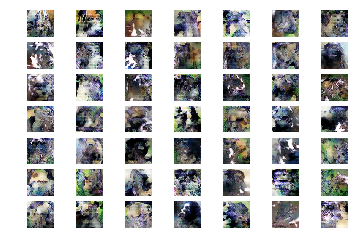

>44, 1/160, d1=0.581, d2=0.817 g=1.381
>44, 2/160, d1=0.417, d2=0.497 g=1.491
>44, 3/160, d1=0.624, d2=0.502 g=1.439
>44, 4/160, d1=0.581, d2=0.527 g=1.326
>44, 5/160, d1=0.551, d2=0.619 g=1.518
>44, 6/160, d1=0.691, d2=0.454 g=1.559
>44, 7/160, d1=0.693, d2=0.457 g=1.372
>44, 8/160, d1=0.616, d2=0.600 g=1.404
>44, 9/160, d1=0.657, d2=0.546 g=1.457
>44, 10/160, d1=0.564, d2=0.427 g=1.516
>44, 11/160, d1=0.482, d2=0.452 g=1.468
>44, 12/160, d1=0.507, d2=0.468 g=1.451
>44, 13/160, d1=0.527, d2=0.653 g=1.255
>44, 14/160, d1=0.565, d2=0.646 g=1.392
>44, 15/160, d1=0.601, d2=0.468 g=1.357
>44, 16/160, d1=0.592, d2=0.501 g=1.473
>44, 17/160, d1=0.767, d2=0.544 g=1.390
>44, 18/160, d1=0.524, d2=0.526 g=1.338
>44, 19/160, d1=0.535, d2=0.528 g=1.261
>44, 20/160, d1=0.608, d2=0.579 g=1.203
>44, 21/160, d1=0.397, d2=0.596 g=1.453
>44, 22/160, d1=0.480, d2=0.410 g=1.385
>44, 23/160, d1=0.623, d2=0.421 g=1.321
>44, 24/160, d1=0.470, d2=0.523 g=1.370
>44, 25/160, d1=0.446, d2=0.698 g=1.591
>44, 26/1

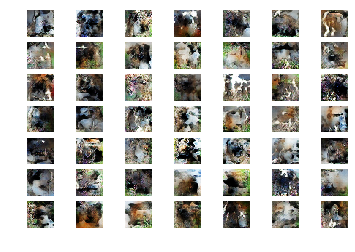

>45, 1/160, d1=0.619, d2=0.449 g=1.343
>45, 2/160, d1=0.599, d2=0.536 g=1.284
>45, 3/160, d1=0.659, d2=0.578 g=1.300
>45, 4/160, d1=0.560, d2=0.553 g=1.297
>45, 5/160, d1=0.515, d2=0.576 g=1.389
>45, 6/160, d1=0.505, d2=0.443 g=1.385
>45, 7/160, d1=0.506, d2=0.407 g=1.427
>45, 8/160, d1=0.548, d2=0.453 g=1.395
>45, 9/160, d1=0.451, d2=0.404 g=1.471
>45, 10/160, d1=0.387, d2=0.444 g=1.510
>45, 11/160, d1=0.418, d2=0.378 g=1.495
>45, 12/160, d1=0.436, d2=0.493 g=1.608
>45, 13/160, d1=0.393, d2=0.435 g=1.628
>45, 14/160, d1=0.548, d2=0.447 g=1.504
>45, 15/160, d1=0.507, d2=0.714 g=1.642
>45, 16/160, d1=0.585, d2=0.395 g=1.655
>45, 17/160, d1=0.641, d2=0.531 g=1.454
>45, 18/160, d1=0.453, d2=0.780 g=1.566
>45, 19/160, d1=0.793, d2=0.450 g=1.575
>45, 20/160, d1=0.807, d2=0.494 g=1.304
>45, 21/160, d1=0.625, d2=0.558 g=1.249
>45, 22/160, d1=0.549, d2=0.616 g=1.477
>45, 23/160, d1=0.734, d2=0.418 g=1.385
>45, 24/160, d1=0.719, d2=0.433 g=1.183
>45, 25/160, d1=0.452, d2=0.659 g=1.259
>45, 26/1

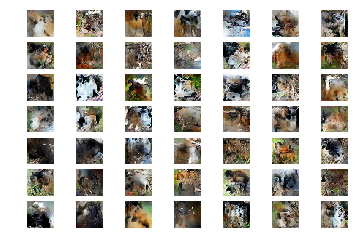

>46, 1/160, d1=0.661, d2=0.659 g=1.204
>46, 2/160, d1=0.551, d2=0.510 g=1.283
>46, 3/160, d1=0.637, d2=0.490 g=1.265
>46, 4/160, d1=0.504, d2=0.584 g=1.364
>46, 5/160, d1=0.601, d2=0.519 g=1.294
>46, 6/160, d1=0.473, d2=0.607 g=1.385
>46, 7/160, d1=0.402, d2=0.453 g=1.433
>46, 8/160, d1=0.599, d2=0.494 g=1.377
>46, 9/160, d1=0.572, d2=0.495 g=1.256
>46, 10/160, d1=0.639, d2=0.641 g=1.388
>46, 11/160, d1=0.601, d2=0.491 g=1.401
>46, 12/160, d1=0.638, d2=0.640 g=1.235
>46, 13/160, d1=0.554, d2=0.522 g=1.297
>46, 14/160, d1=0.620, d2=0.628 g=1.350
>46, 15/160, d1=0.623, d2=0.547 g=1.341
>46, 16/160, d1=0.602, d2=0.910 g=2.091
>46, 17/160, d1=0.650, d2=0.303 g=1.976
>46, 18/160, d1=0.653, d2=0.552 g=1.421
>46, 19/160, d1=0.530, d2=0.526 g=1.737
>46, 20/160, d1=0.612, d2=0.410 g=1.603
>46, 21/160, d1=0.607, d2=0.453 g=1.471
>46, 22/160, d1=0.595, d2=0.618 g=1.516
>46, 23/160, d1=0.590, d2=0.750 g=1.292
>46, 24/160, d1=0.544, d2=0.568 g=1.350
>46, 25/160, d1=0.542, d2=0.479 g=1.276
>46, 26/1

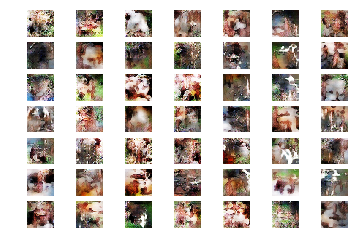

>47, 1/160, d1=0.585, d2=0.492 g=1.435
>47, 2/160, d1=0.731, d2=0.546 g=1.464
>47, 3/160, d1=0.716, d2=0.486 g=1.395
>47, 4/160, d1=0.620, d2=0.531 g=1.402
>47, 5/160, d1=0.672, d2=0.511 g=1.386
>47, 6/160, d1=0.543, d2=0.518 g=1.227
>47, 7/160, d1=0.566, d2=0.541 g=1.203
>47, 8/160, d1=0.554, d2=0.561 g=1.193
>47, 9/160, d1=0.514, d2=0.601 g=1.218
>47, 10/160, d1=0.555, d2=0.443 g=1.347
>47, 11/160, d1=0.552, d2=0.558 g=1.257
>47, 12/160, d1=0.490, d2=0.555 g=1.351
>47, 13/160, d1=0.442, d2=0.466 g=1.381
>47, 14/160, d1=0.572, d2=0.549 g=1.374
>47, 15/160, d1=0.585, d2=0.504 g=1.385
>47, 16/160, d1=0.584, d2=0.486 g=1.316
>47, 17/160, d1=0.454, d2=0.515 g=1.373
>47, 18/160, d1=0.579, d2=0.487 g=1.394
>47, 19/160, d1=0.501, d2=0.513 g=1.409
>47, 20/160, d1=0.626, d2=0.519 g=1.328
>47, 21/160, d1=0.509, d2=0.447 g=1.273
>47, 22/160, d1=0.406, d2=0.588 g=1.314
>47, 23/160, d1=0.527, d2=0.589 g=1.416
>47, 24/160, d1=0.599, d2=0.519 g=1.341
>47, 25/160, d1=0.629, d2=0.483 g=1.300
>47, 26/1

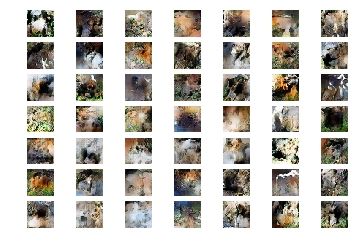

>48, 1/160, d1=0.619, d2=0.431 g=1.440
>48, 2/160, d1=0.486, d2=0.535 g=1.404
>48, 3/160, d1=0.455, d2=0.450 g=1.474
>48, 4/160, d1=0.440, d2=0.518 g=1.453
>48, 5/160, d1=0.550, d2=0.430 g=1.427
>48, 6/160, d1=0.473, d2=0.473 g=1.360
>48, 7/160, d1=0.526, d2=0.577 g=1.206
>48, 8/160, d1=0.646, d2=0.573 g=1.303
>48, 9/160, d1=0.619, d2=0.582 g=1.396
>48, 10/160, d1=0.686, d2=0.487 g=1.379
>48, 11/160, d1=0.612, d2=0.483 g=1.401
>48, 12/160, d1=0.626, d2=0.493 g=1.351
>48, 13/160, d1=0.558, d2=0.482 g=1.343
>48, 14/160, d1=0.524, d2=0.570 g=1.536
>48, 15/160, d1=0.607, d2=0.596 g=1.537
>48, 16/160, d1=0.618, d2=0.564 g=1.477
>48, 17/160, d1=0.531, d2=0.595 g=1.600
>48, 18/160, d1=0.629, d2=0.353 g=1.553
>48, 19/160, d1=0.568, d2=0.495 g=1.393
>48, 20/160, d1=0.547, d2=0.563 g=1.443
>48, 21/160, d1=0.594, d2=0.474 g=1.442
>48, 22/160, d1=0.504, d2=0.536 g=1.544
>48, 23/160, d1=0.478, d2=0.416 g=1.505
>48, 24/160, d1=0.568, d2=0.482 g=1.492
>48, 25/160, d1=0.560, d2=0.613 g=1.515
>48, 26/1

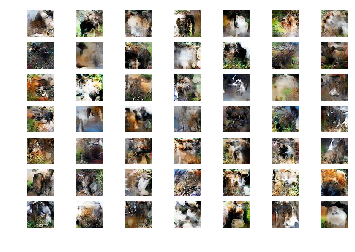

>49, 1/160, d1=0.406, d2=0.589 g=1.204
>49, 2/160, d1=0.582, d2=0.610 g=1.287
>49, 3/160, d1=0.606, d2=0.553 g=1.212
>49, 4/160, d1=0.605, d2=0.538 g=1.272
>49, 5/160, d1=0.580, d2=0.560 g=1.270
>49, 6/160, d1=0.502, d2=0.544 g=1.321
>49, 7/160, d1=0.665, d2=0.587 g=1.254
>49, 8/160, d1=0.552, d2=0.506 g=1.293
>49, 9/160, d1=0.568, d2=0.558 g=1.308
>49, 10/160, d1=0.597, d2=0.474 g=1.306
>49, 11/160, d1=0.592, d2=0.497 g=1.266
>49, 12/160, d1=0.525, d2=0.588 g=1.330
>49, 13/160, d1=0.614, d2=0.488 g=1.433
>49, 14/160, d1=0.602, d2=0.550 g=1.435
>49, 15/160, d1=0.518, d2=0.486 g=1.451
>49, 16/160, d1=0.490, d2=0.510 g=1.503
>49, 17/160, d1=0.526, d2=0.434 g=1.524
>49, 18/160, d1=0.525, d2=0.470 g=1.491
>49, 19/160, d1=0.513, d2=0.548 g=1.483
>49, 20/160, d1=0.537, d2=0.583 g=1.416
>49, 21/160, d1=0.643, d2=0.506 g=1.539
>49, 22/160, d1=0.654, d2=0.526 g=1.377
>49, 23/160, d1=0.582, d2=0.569 g=1.447
>49, 24/160, d1=0.653, d2=0.546 g=1.409
>49, 25/160, d1=0.611, d2=0.461 g=1.422
>49, 26/1

In [9]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
# dataset = load_real_samples()
dataset = load_images()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

In [10]:
# Submission
def save_images(generator):
    if not os.path.exists('../output'):
        os.mkdir('../output')

    latent_points = generate_latent_points(100, 10000)
    generated_images = generator.predict(latent_points)

    for i in range(generated_images.shape[0]):
        image = denormalize_image(generated_images[i])
        image = array_to_img(image)
        image.save('../output/' + str(i) + '.png')

    shutil.make_archive('images', 'zip', '../output')


save_images(g_model)